# This file is to collect the data, compare and storing it in csv files
- step 1 : collecting the 20 text classification and text generation models data ( name ,type ,updated date, downloaded , liked)
- step 2 : collecting the app counts associated with the models obtained in the step 1
- step 3 : collecting the source size of the apps found in the step 3
- step 4 : clearning data ( duplicate removing )
- step 5 : Merging all the previously obtained data in to a single csv for each classification and generation model.

### Importing the necessary libraries 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json
from time import sleep
import nest_asyncio
import asyncio
import aiohttp
import concurrent.futures
import ast

# Step 1: Obtaining 20 text classification and text generation models list

In [2]:
# Step 1: Obtain a list of the top-20 "Text Classification" models
# sorted and filterd based of most downloads

classification_url = "https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads"
classification_models = []

#capturing the web response , response type html
response = requests.get(classification_url)
soup = BeautifulSoup(response.content, "html.parser")
model_list = soup.find_all("article", class_="overview-card-wrapper")

# collecting data for first 20 text classification models
for model in model_list[:20]:
    model_name = model.find("header", class_="flex items-center mb-0.5").text.strip()
    model_details  = model.find("div", class_="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400").text.replace("\t","*").replace('\n', '*').replace('• ',"*").strip('').split("*")
    model_details =list(filter(bool, model_details))
    m_type= model_details[0]
    updated = model_details[2]
    downloaded= model_details[3]
    liked= model_details[4]
    dic = {
        "model_name": model_name,
        "model_type": m_type,
        "updated" : updated,
        "downloaded" : downloaded,
        "liked" : liked
    }
    # print(dic,end="\n")
    classification_models.append(dic)

In [3]:
# Obtain a list of the top-20 text generation models
# sorted and filterd based of most downloads

generation_url = "https://huggingface.co/models?pipeline_tag=text-generation&sort=downloads"
generation_models = []

#capturing the web response , response type html
response = requests.get(generation_url)
soup = BeautifulSoup(response.content, "html.parser")
model_list = soup.find_all("article", class_="overview-card-wrapper")

# collecting data for first 20 text generation models
for model in model_list[:20]:
    model_name = model.find("header", class_="flex items-center mb-0.5").text.strip()
    model_details  = model.find("div", class_="mr-1 flex items-center overflow-hidden whitespace-nowrap text-sm leading-tight text-gray-400").text.replace("\t","*").replace('\n', '*').replace('• ',"*").strip('').split("*")
    model_details =list(filter(bool, model_details))
    m_type= model_details[0]
    updated = model_details[2]
    downloaded= model_details[3]
    liked= model_details[4]
    dic = {
        "model_name": model_name,
        "model_type": m_type,
        "updated" : updated,
        "downloaded" : downloaded,
        "liked" : liked
    }
    # print(dic,end="\n")
    generation_models.append(dic)

### Creating a csv file from the data obtained from step 1

In [7]:
# Resuable function for saving data into csv format
# First load the list into a panda dataframe 
# then create a csv using pandas build in to_csv() method
def save_to_csv(data,filename):
    data_df=pd.DataFrame(data)
    data_df.to_csv(f"all_csv_data/{filename}",index=False)
    

In [8]:
save_to_csv(classification_models,"classification_models.csv")
save_to_csv(generation_models,"generation_models.csv")

# Step 2: Obtain and compare the number of ML apps ("spaces") for each "Text Classification" and "text generation" model

In [9]:
# function for finding the targeted element
def find_elements(html, parent_selector):
    soup = BeautifulSoup(html, 'html.parser')
    parent_tag = soup.select_one(parent_selector)
  
    temp={
    "linkedSpaces" : []
    }
    return parent_tag.get('data-props') if parent_tag is not None else json.dumps(temp)
  

In [10]:
nest_asyncio.apply()
# asynchronous network call to faster execution time and parallel task execution
async def fetch_linked_spaces(model_name, session):
    model_url = f"https://huggingface.co/{model_name['model_name']}"
    async with session.get(model_url) as response:
        data = []
        if response.status == 200:
            content = await response.text()
            soup = BeautifulSoup(content, "html.parser")
            linked_spaces = soup.find_all(attrs={"data-target": "LinkedSpacesList"})
            # print(linked_spaces)
            if linked_spaces:
                data = [item['id'] for item in json.loads(linked_spaces[0].get('data-props'))['linkedSpaces']]
                
        return {
            "model_name": model_name['model_name'],
            "model_url": model_url,
            "app_list": data,
            "total_app": len(data)
        }

async def get_app_count(models):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_linked_spaces(model_name, session) for model_name in models]
        app_count = await asyncio.gather(*tasks)
    return app_count

async def main():
    class_app_count = await get_app_count(classification_models)
    gen_app_count = await get_app_count(generation_models)
    return class_app_count,gen_app_count

loop = asyncio.get_event_loop()
classification_app_count,generation_app_count = loop.run_until_complete(main())

In [11]:
save_to_csv(classification_app_count,"classification_app_count.csv")
save_to_csv(generation_app_count,"generation_app_count.csv")

## Compared between text classification and text generation model based on step 2 (app count)

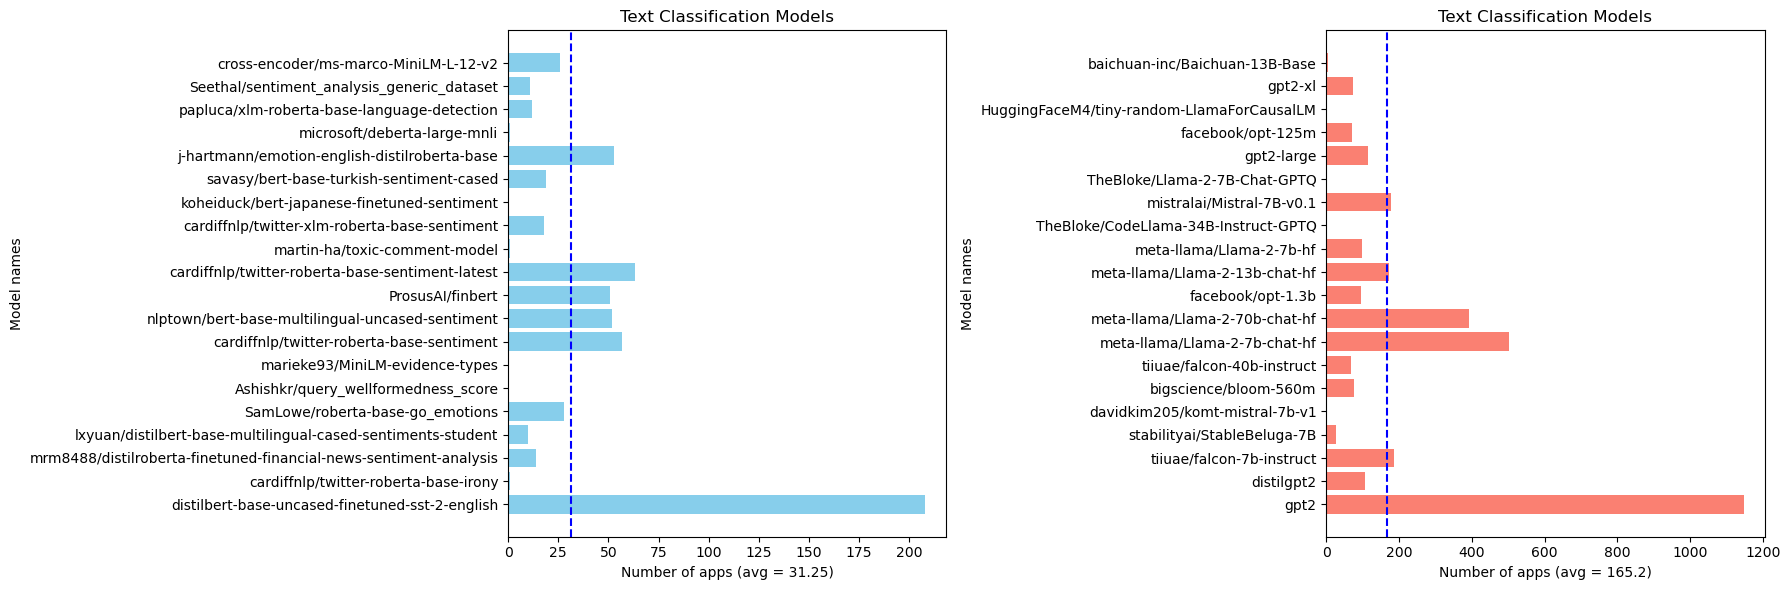

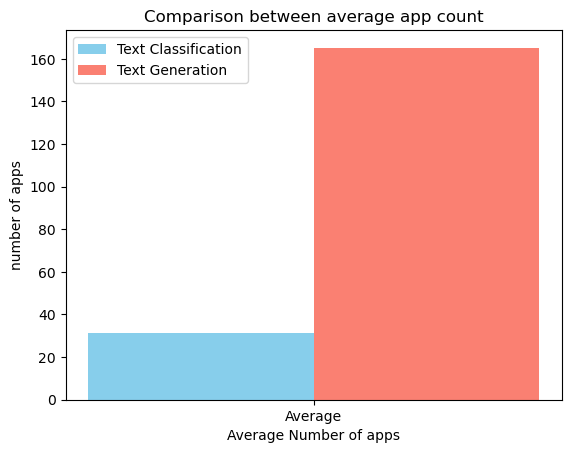

In [139]:
# Create DataFrames
df1 = pd.DataFrame(classification_app_count)
df2 = pd.DataFrame(generation_app_count)

# Set the figure size
plt.figure(figsize=(18, 6))

# Plotting the first bar chart
plt.subplot(1, 2, 1)
plt.barh(df1["model_name"].values, df1["total_app"].values, color='skyblue')
average1 = sum(df1["total_app"].values) / len(df1["total_app"].values)
plt.axvline(average1, color='b', linestyle='--', label='Average')

plt.xlabel(f'Number of apps (avg = {average1})')
plt.ylabel(f'Model names')
plt.title('Text Classification Models')


# Plotting the second bar chart
plt.subplot(1, 2, 2)
plt.barh(df2["model_name"].values, df2["total_app"].values, color='salmon')
average2 = sum(df2["total_app"].values) / len(df2["total_app"].values)
plt.axvline(average2, color='b', linestyle='--', label='Average')

plt.xlabel(f'Number of apps (avg = {average2})')
plt.ylabel(f'Model names')
plt.title('Text Classification Models')

# Adjust layout for better spacing
plt.tight_layout()

#  Grouped Bar Chart
labels = ['Average']

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, average1, width, label='Text Classification',color="skyblue")
rects2 = ax.bar([i + width for i in x], average2, width, label='Text Generation',color="salmon")

ax.set_xlabel('Average Number of apps')
ax.set_ylabel('number of apps')
ax.set_title('Comparison between average app count')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
# Show the plot
plt.show()

# Step 3 :obtain and compare the source code size of the ML apps ("spaces") obtained in step 2 

In [12]:
# converting kb to bytes to store size in bytes
def kb_to_bytes(kb):
    s_bytes = kb * 1024
    return s_bytes

In [13]:
nest_asyncio.apply()
# asynchronous network call to faster execution time and parallel task execution
async def fetch_code_size(session, space):
    space_url = f"https://huggingface.co/spaces/{space}/tree/main"
    async with session.get(space_url) as response:
        space_soup = BeautifulSoup(await response.text(), "html.parser")
        file_download_selector = '[title="Download file"]'
        available_files = space_soup.select(file_download_selector)
        code_size = sum([float(file.text.split(" ")[0]) if file.text.split(" ")[1].strip() != "kB" else kb_to_bytes(float(file.text.split(" ")[0])) for file in available_files])
    return {"app_name": space, "size": code_size}

async def get_app_source_size(app_count):
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_code_size(session, space) for x in app_count for space in x["app_list"]]
        app_source_size = await asyncio.gather(*tasks)
    return app_source_size


async def source_size_calc():
    class_app_sizes= await get_app_source_size(classification_app_count)
    gen_app_sizes = await get_app_source_size(generation_app_count)
    return class_app_sizes, gen_app_sizes

loop = asyncio.get_event_loop()
class_app_source_sizes,gen_app_source_sizes=loop.run_until_complete(source_size_calc())

### Compared the source size found in step 3 between text classification and text generation apps

<Figure size 1800x600 with 0 Axes>

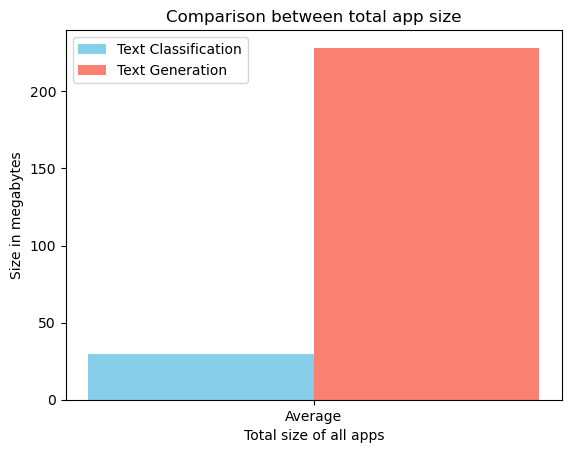

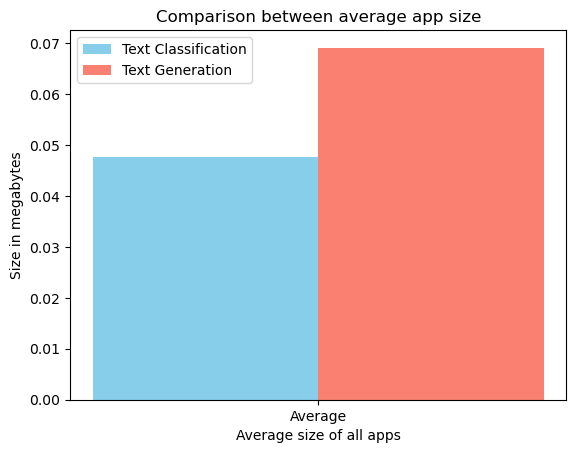

In [151]:
# Create DataFrames
df1 = pd.DataFrame(class_app_source_sizes)
df2 = pd.DataFrame(gen_app_source_sizes)

df1_size=df1['size'].values
df2_size=df2['size'].values

# Set the figure size
plt.figure(figsize=(18, 6))
# labels = ['Average']

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, sum(df1_size)/ (1024 * 1024), width, label='Text Classification',color="skyblue")
rects2 = ax.bar([i + width for i in x], sum(df2_size)/ (1024 * 1024), width, label='Text Generation',color="salmon")

ax.set_xlabel('Total size of all apps')
ax.set_ylabel('Size in megabytes')
ax.set_title('Comparison between total app size')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels("Total")
ax.legend()


average1 = sum(df1_size) / len(df1_size)
average2 = sum(df2_size) / len(df2_size)

# Example 2: Grouped Bar Chart
# labels = ['Average']

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, average1/ (1024 * 1024), width, label='Text Classification',color="skyblue")
rects2 = ax.bar([i + width for i in x], average2/ (1024 * 1024), width, label='Text Generation',color="salmon")

ax.set_xlabel('Average size of all apps')
ax.set_ylabel('Size in megabytes')
ax.set_title('Comparison between average app size')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
# Show the plot
plt.show()

# Step 4:  Some Data cleaning
- droping the duplicate values (as multiple app can use same model)

In [15]:
# converting python list into panda dataframe
class_df= pd.DataFrame(class_app_source_sizes)
gen_df= pd.DataFrame(gen_app_source_sizes)

In [16]:
# droping the duplicate values (as multiple app can use same model)
gen_df.drop_duplicates(inplace=True)
class_df.drop_duplicates(inplace=True)

In [19]:
class_df.to_csv("all_csv_data/class_app_source_sizes.csv",index=False)
gen_df.to_csv("all_csv_data/gen_app_source_sizes.csv",index=False)

In [ ]:
# all_model_names = [item['model_name'] for item in classification_app_count]
# total_apps = [item['total_app'] for item in classification_app_count]

# plt.barh(all_model_names, total_apps)

# average = sum(total_apps) / len(total_apps)
# plt.axvline(average, color='y', linestyle='--', label='Average')

# plt.ylabel('Model Name')
# plt.xlabel(f'Total App Count ( total = {sum(total_apps)}, avg = {average})')
# plt.title('App Count for Text Classification Models')
# plt.show()


In [ ]:
# all_model_names = [item['model_name'] for item in generation_app_count]
# total_apps = [item['total_app'] for item in generation_app_count]

# plt.barh(all_model_names, total_apps)

# average = sum(total_apps) / len(total_apps)
# plt.axvline(average, color='y', linestyle='--', label='Average')

# plt.ylabel('Model Name')
# plt.xlabel(f'Total App Count ( total = {sum(total_apps)}, avg = {average})')
# plt.title('App Count for Text Generation Models')
# plt.show()

# Step 5: Merging all individual obtained value into one CSV for both text classification and text generation models
- First merging step 1 obtaied data with step 2 obtained data using a common field called 'model_name'
- Obtained data from the previous step has all the necessary columns and values from task step 1 and step 2
- finally, will add a new column app_sizes to the previously retained data
- app_sizes will contain list of the app's size in same order as app_list for a individual model

In [20]:
# reusable merging funciton
def merge_csv_into_one(model_csv, app_count_csv, app_source_size_csv):
    models_data= pd.read_csv(model_csv)
    app_count_data=pd.read_csv(app_count_csv)
    app_source_size_csv = pd.read_csv(app_source_size_csv)
    
    # merging step 1 and step 2 data into one
    models_data = pd.merge(models_data,app_count_data, on ='model_name')
    
    # merging previously merged data and step 3
    app_dict = dict(zip(app_source_size_csv['app_name'], app_source_size_csv['size']))

    # Create a function to retrieve app sizes based on the space_list
    def get_app_sizes(space_list):
        space_list=ast.literal_eval(space_list)
        return [app_dict.get(app_name) for app_name in space_list]

    models_data['app_sizes'] = models_data['app_list'].apply(get_app_sizes)
    return models_data

In [22]:
class_data_merged= merge_csv_into_one("all_csv_data/classification_models.csv","all_csv_data/classification_app_count.csv","all_csv_data/class_app_source_sizes.csv")
gen_data_merged = merge_csv_into_one("all_csv_data/generation_models.csv","all_csv_data/generation_app_count.csv","all_csv_data/gen_app_source_sizes.csv")


### First 5 rows of data of text classification csv

In [23]:
class_data_merged.head()

,model_name,model_type,updated,downloaded,liked,model_url,app_list,total_app,app_sizes
0,distilbert-base-uncased-finetuned-sst-2-english,Text Classification,Oct 26,32.2M,354,https://huggingface.co/distilbert-base-uncased...,"['microsoft/HuggingGPT', 'society-ethics/model...",208,"[88343.64, 9619.24, 142854.32, 229976.2, 15153..."
1,cardiffnlp/twitter-roberta-base-irony,Text Classification,Aug 2,6.77M,13,https://huggingface.co/cardiffnlp/twitter-robe...,['Eberhenriquez/cardiffnlp-twitter-roberta-bas...,1,[1927.48]
2,mrm8488/distilroberta-finetuned-financial-news...,Text Classification,Mar 16,6.52M,123,https://huggingface.co/mrm8488/distilroberta-f...,"['sohomghosh/FLUEnT', 'Anthos23/hummus', 'niko...",14,"[22595.450000000004, 2607.92, 4103.88, 3924.2,..."
3,lxyuan/distilbert-base-multilingual-cased-sent...,Text Classification,Jun 24,6.51M,54,https://huggingface.co/lxyuan/distilbert-base-...,['jingwora/language-emotion-classification-sen...,10,"[4370.56, 21825.76, 9136.08, 25861.08, 22069.5..."
4,SamLowe/roberta-base-go_emotions,Text Classification,Oct 4,6.5M,190,https://huggingface.co/SamLowe/roberta-base-go...,['Pontonkid/Real-Time-Multilingual-sentiment-a...,28,"[6954.07, 3583.28, 1888.48, 6157.48, 1917.48, ..."


In [26]:
### First 5 rows of data of text generation csv

In [24]:
gen_data_merged.head()

,model_name,model_type,updated,downloaded,liked,model_url,app_list,total_app,app_sizes
0,gpt2,Text Generation,Jun 30,22M,1.51k,https://huggingface.co/gpt2,"['HuggingFaceH4/open_llm_leaderboard', 'micros...",1147,"[19864.64, 88343.64, 3860.82, 60292.2400000000..."
1,distilgpt2,Text Generation,Apr 29,10.7M,275,https://huggingface.co/distilgpt2,"['h2oai/h2ogpt-chatbot', 'multimodalart/mariog...",105,"[20004.52, 9047.16, 18895.64, 180735.34, 16380..."
2,tiiuae/falcon-7b-instruct,Text Generation,Sep 29,7.33M,754,https://huggingface.co/tiiuae/falcon-7b-instruct,"['h2oai/h2ogpt-chatbot', 'h2oai/h2ogpt-chatbot...",187,"[20004.52, 18895.64, 46087.32, 7106.6399999999..."
3,stabilityai/StableBeluga-7B,Text Generation,Aug 29,3.09M,124,https://huggingface.co/stabilityai/StableBelug...,"['HuggingFaceH4/open_llm_leaderboard', 'upstag...",27,"[19864.64, 30901.22, 46087.32, 74241.91, 7100...."
4,davidkim205/komt-mistral-7b-v1,Text Generation,Oct 24,1.33M,5,https://huggingface.co/davidkim205/komt-mistra...,[],0,[]


In [25]:
# saving the merged data into a csv 
class_data_merged.to_csv("all_csv_data/Classification_model_full_data.csv",index=False)
gen_data_merged.to_csv("all_csv_data/Generation_mode_full_data.csv",index=False)

# From her the analysis part begin
- step 1 : Compare the number of apps available in the space for each type of the model
- step 2 : Comapre the app size and average size for each type of the model
- step 3 : Make a comment based on the previous steps

In [29]:
# loading classification and generation csv files using pandas
classification_info= pd.read_csv("all_csv_data/Classification_model_full_data.csv")
generation_info= pd.read_csv("all_csv_data/Generation_mode_full_data.csv")

In [30]:
classification_info.head()

,model_name,model_type,updated,downloaded,liked,model_url,app_list,total_app,app_sizes
0,distilbert-base-uncased-finetuned-sst-2-english,Text Classification,Oct 26,32.2M,354,https://huggingface.co/distilbert-base-uncased...,"['microsoft/HuggingGPT', 'society-ethics/model...",208,"[88343.64, 9619.24, 142854.32, 229976.2, 15153..."
1,cardiffnlp/twitter-roberta-base-irony,Text Classification,Aug 2,6.77M,13,https://huggingface.co/cardiffnlp/twitter-robe...,['Eberhenriquez/cardiffnlp-twitter-roberta-bas...,1,[1927.48]
2,mrm8488/distilroberta-finetuned-financial-news...,Text Classification,Mar 16,6.52M,123,https://huggingface.co/mrm8488/distilroberta-f...,"['sohomghosh/FLUEnT', 'Anthos23/hummus', 'niko...",14,"[22595.450000000004, 2607.92, 4103.88, 3924.2,..."
3,lxyuan/distilbert-base-multilingual-cased-sent...,Text Classification,Jun 24,6.51M,54,https://huggingface.co/lxyuan/distilbert-base-...,['jingwora/language-emotion-classification-sen...,10,"[4370.56, 21825.76, 9136.08, 25861.08, 22069.5..."
4,SamLowe/roberta-base-go_emotions,Text Classification,Oct 4,6.5M,190,https://huggingface.co/SamLowe/roberta-base-go...,['Pontonkid/Real-Time-Multilingual-sentiment-a...,28,"[6954.07, 3583.28, 1888.48, 6157.48, 1917.48, ..."


In [31]:
generation_info.head()

,model_name,model_type,updated,downloaded,liked,model_url,app_list,total_app,app_sizes
0,gpt2,Text Generation,Jun 30,22M,1.51k,https://huggingface.co/gpt2,"['HuggingFaceH4/open_llm_leaderboard', 'micros...",1147,"[19864.64, 88343.64, 3860.82, 60292.2400000000..."
1,distilgpt2,Text Generation,Apr 29,10.7M,275,https://huggingface.co/distilgpt2,"['h2oai/h2ogpt-chatbot', 'multimodalart/mariog...",105,"[20004.52, 9047.16, 18895.64, 180735.34, 16380..."
2,tiiuae/falcon-7b-instruct,Text Generation,Sep 29,7.33M,754,https://huggingface.co/tiiuae/falcon-7b-instruct,"['h2oai/h2ogpt-chatbot', 'h2oai/h2ogpt-chatbot...",187,"[20004.52, 18895.64, 46087.32, 7106.6399999999..."
3,stabilityai/StableBeluga-7B,Text Generation,Aug 29,3.09M,124,https://huggingface.co/stabilityai/StableBelug...,"['HuggingFaceH4/open_llm_leaderboard', 'upstag...",27,"[19864.64, 30901.22, 46087.32, 74241.91, 7100...."
4,davidkim205/komt-mistral-7b-v1,Text Generation,Oct 24,1.33M,5,https://huggingface.co/davidkim205/komt-mistra...,[],0,[]
